In [0]:
%matplotlib inline

In [2]:
!pip install torchsummary
!pip install albumentations
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Common/')

In [5]:
from models import *
from utils import *
from data_loaders import *
from train import *
import validation as test
from graph import *
from albumentation import *
from albumentations import Normalize, HorizontalFlip, VerticalFlip, Rotate, Cutout
from gradCAM import *
from lr_finder import *

  pip install torch-lr-finder -v --global-option="amp"


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
BATCH_SIZE = 128
EPOCHS = 50
device = getDevice()
dataloader_args = getDataLoaderArgs(BATCH_SIZE)
train_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                              Cutout(num_holes=1, max_h_size=16, max_w_size = 16,p=0.5),
                              HorizontalFlip(),
                                # Rotate(limit=45)
                                ]
train_data_transfomrs = getAlbumTransformation(train_data_transforms_list)
trainloader = getTrainDataLoader("CIFAR", dataloader_args, train_data_transfomrs)
test_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
test_data_transfomrs = getAlbumTransformation(test_data_transforms_list)
testloader = getTestDataLoader("CIFAR", dataloader_args, test_data_transfomrs)
model = MyResNet18().to(device)
summary(model, input_size=(3, 32, 32))



CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
      


Learning rate search finished. See the graph with {finder_name}.plot()


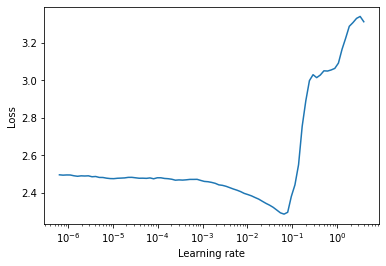

0.06579332246575682
Best Loss :  2.28454141559734


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot()
lr_finder.reset()
print(lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)])
print('Best Loss : ',lr_finder.best_loss)

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
# optimizer = getOptimizer(model, lr=0.5, momentum=0.9, weight_decay=0.00005)
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.01, min_lr=0.0005)
all_train_acc = []

for epoch in range(EPOCHS):
  running_loss = 0
  print('EPOCH : ', epoch)
  train(model, device, trainloader, optimizer, criterion)
  all_train_acc.append(train_acc[-1])
  test.__test(model, device, testloader, criterion)
  scheduler.step(running_loss)
  

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH :  0


Loss=1.6359964609146118 Batch_id=390 Accuracy=23.84: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 3621/10000 (36.21%)

EPOCH :  1


Loss=1.4831199645996094 Batch_id=390 Accuracy=42.04: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 4840/10000 (48.40%)

EPOCH :  2


Loss=1.092095136642456 Batch_id=390 Accuracy=54.20: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6076/10000 (60.76%)

EPOCH :  3


Loss=0.8666790127754211 Batch_id=390 Accuracy=63.77: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6269/10000 (62.69%)

EPOCH :  4


Loss=0.6775072813034058 Batch_id=390 Accuracy=69.67: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6972/10000 (69.72%)

EPOCH :  5


Loss=0.6377075910568237 Batch_id=390 Accuracy=74.47: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6911/10000 (69.11%)

EPOCH :  6


Loss=0.6455960869789124 Batch_id=390 Accuracy=77.84: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7759/10000 (77.59%)

EPOCH :  7


Loss=0.7398149371147156 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7892/10000 (78.92%)

EPOCH :  8


Loss=0.47095662355422974 Batch_id=390 Accuracy=81.71: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7913/10000 (79.13%)

EPOCH :  9


Loss=0.5879413485527039 Batch_id=390 Accuracy=83.44: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7901/10000 (79.01%)

EPOCH :  10


Loss=0.4867427349090576 Batch_id=390 Accuracy=84.53: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8229/10000 (82.29%)

EPOCH :  11


Loss=0.4156298041343689 Batch_id=390 Accuracy=85.48: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8271/10000 (82.71%)

Epoch    12: reducing learning rate of group 0 to 5.0000e-02.
EPOCH :  12


Loss=0.20519089698791504 Batch_id=390 Accuracy=91.08: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8933/10000 (89.33%)

EPOCH :  13


Loss=0.2757044732570648 Batch_id=390 Accuracy=92.65: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8995/10000 (89.95%)

EPOCH :  14


Loss=0.10491345822811127 Batch_id=390 Accuracy=93.39: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8987/10000 (89.87%)

EPOCH :  15


Loss=0.11164011806249619 Batch_id=390 Accuracy=93.98: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9035/10000 (90.35%)

EPOCH :  16


Loss=0.09453165531158447 Batch_id=390 Accuracy=94.43: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9027/10000 (90.27%)

EPOCH :  17


Loss=0.14745916426181793 Batch_id=390 Accuracy=94.73: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9044/10000 (90.44%)

EPOCH :  18


Loss=0.16187261044979095 Batch_id=390 Accuracy=95.30: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9027/10000 (90.27%)

EPOCH :  19


Loss=0.2276051938533783 Batch_id=390 Accuracy=95.62: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9028/10000 (90.28%)

EPOCH :  20


Loss=0.09158070385456085 Batch_id=390 Accuracy=95.95: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9049/10000 (90.49%)

EPOCH :  21


Loss=0.13564057648181915 Batch_id=390 Accuracy=96.18: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9050/10000 (90.50%)

EPOCH :  22


Loss=0.06944657862186432 Batch_id=390 Accuracy=96.40: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9046/10000 (90.46%)

Epoch    23: reducing learning rate of group 0 to 5.0000e-03.
EPOCH :  23


Loss=0.12170735746622086 Batch_id=390 Accuracy=97.15: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9092/10000 (90.92%)

EPOCH :  24


Loss=0.10069634765386581 Batch_id=390 Accuracy=97.31: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9114/10000 (91.14%)

EPOCH :  25


Loss=0.06342680752277374 Batch_id=390 Accuracy=97.56: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9114/10000 (91.14%)

EPOCH :  26


Loss=0.1341015100479126 Batch_id=390 Accuracy=97.43: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9108/10000 (91.08%)

EPOCH :  27


Loss=0.11075390875339508 Batch_id=390 Accuracy=97.56: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9097/10000 (90.97%)

EPOCH :  28


Loss=0.04027498513460159 Batch_id=390 Accuracy=97.63: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9089/10000 (90.89%)

EPOCH :  29


Loss=0.11378604173660278 Batch_id=390 Accuracy=97.66: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9101/10000 (91.01%)

EPOCH :  30


Loss=0.08517582714557648 Batch_id=390 Accuracy=97.71: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9106/10000 (91.06%)

EPOCH :  31


Loss=0.03672441095113754 Batch_id=390 Accuracy=97.80: 100%|██████████| 391/391 [00:33<00:00, 11.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9114/10000 (91.14%)

EPOCH :  32


Loss=0.04977850988507271 Batch_id=390 Accuracy=97.86: 100%|██████████| 391/391 [00:33<00:00, 11.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9107/10000 (91.07%)

EPOCH :  33


Loss=0.06350039690732956 Batch_id=390 Accuracy=97.88: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9123/10000 (91.23%)

Epoch    34: reducing learning rate of group 0 to 5.0000e-04.
EPOCH :  34


Loss=0.12276975065469742 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9126/10000 (91.26%)

EPOCH :  35


Loss=0.10599376261234283 Batch_id=390 Accuracy=97.91: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9123/10000 (91.23%)

EPOCH :  36


Loss=0.08722846210002899 Batch_id=390 Accuracy=97.91: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9137/10000 (91.37%)

EPOCH :  37


Loss=0.0703149065375328 Batch_id=390 Accuracy=97.80: 100%|██████████| 391/391 [00:33<00:00, 11.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9119/10000 (91.19%)

EPOCH :  38


Loss=0.09083154052495956 Batch_id=390 Accuracy=97.88: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9123/10000 (91.23%)

EPOCH :  39


Loss=0.07547520846128464 Batch_id=390 Accuracy=97.98: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9129/10000 (91.29%)

EPOCH :  40


Loss=0.1284586489200592 Batch_id=390 Accuracy=98.00: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9116/10000 (91.16%)

EPOCH :  41


Loss=0.05223185569047928 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9130/10000 (91.30%)

EPOCH :  42


Loss=0.02240053378045559 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9123/10000 (91.23%)

EPOCH :  43


Loss=0.08240650594234467 Batch_id=390 Accuracy=97.92: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9117/10000 (91.17%)

EPOCH :  44


Loss=0.11425032466650009 Batch_id=390 Accuracy=97.76: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9120/10000 (91.20%)

EPOCH :  45


Loss=0.045069701969623566 Batch_id=390 Accuracy=97.88: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9104/10000 (91.04%)

EPOCH :  46


Loss=0.08739973604679108 Batch_id=390 Accuracy=97.97: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9120/10000 (91.20%)

EPOCH :  47


Loss=0.03135911375284195 Batch_id=390 Accuracy=97.91: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9125/10000 (91.25%)

EPOCH :  48


Loss=0.06629855930805206 Batch_id=390 Accuracy=97.92: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9114/10000 (91.14%)

EPOCH :  49


Loss=0.022383863106369972 Batch_id=390 Accuracy=97.97: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]



Test set: Average loss: 0.0022, Accuracy: 9113/10000 (91.13%)



In [8]:
!mkdir savedModels
import torch
modelName = 'cifar_myresnet18'
torch.save(model.state_dict(), "./savedModels/"+modelName+".pt")

mkdir: cannot create directory ‘savedModels’: File exists


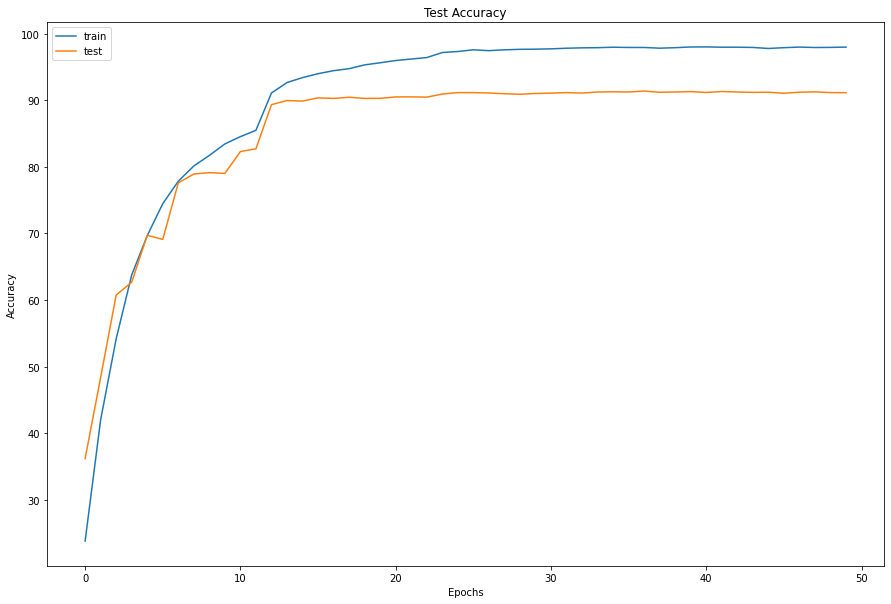

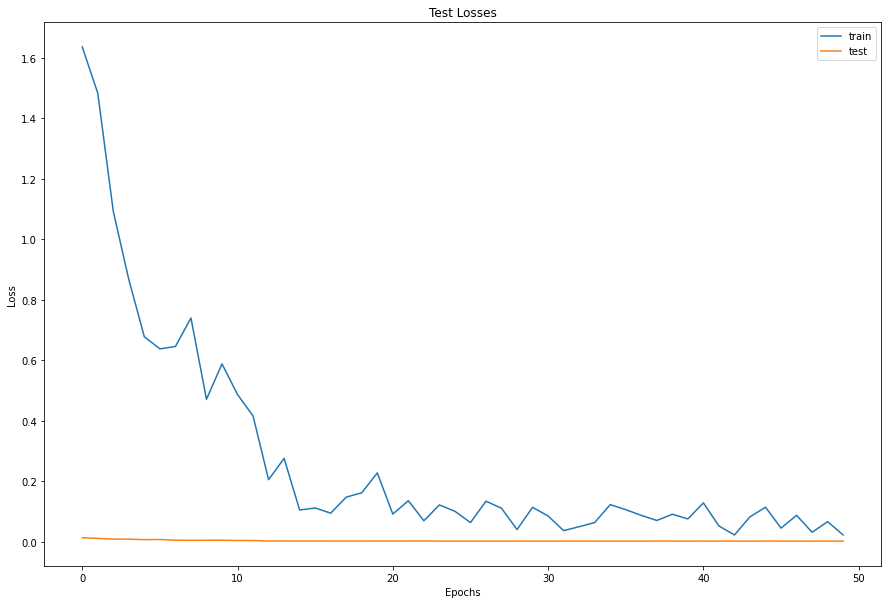

In [10]:
all_test_acc = {'train':all_train_acc,'test':test.test_acc}
plotGraph(all_test_acc, "Test Accuracy","Epochs", "Accuracy")
all_test_loss = {'train':train_losses,'test':test.test_losses}
plotGraph(all_test_loss, "Test Losses","Epochs", "Loss")


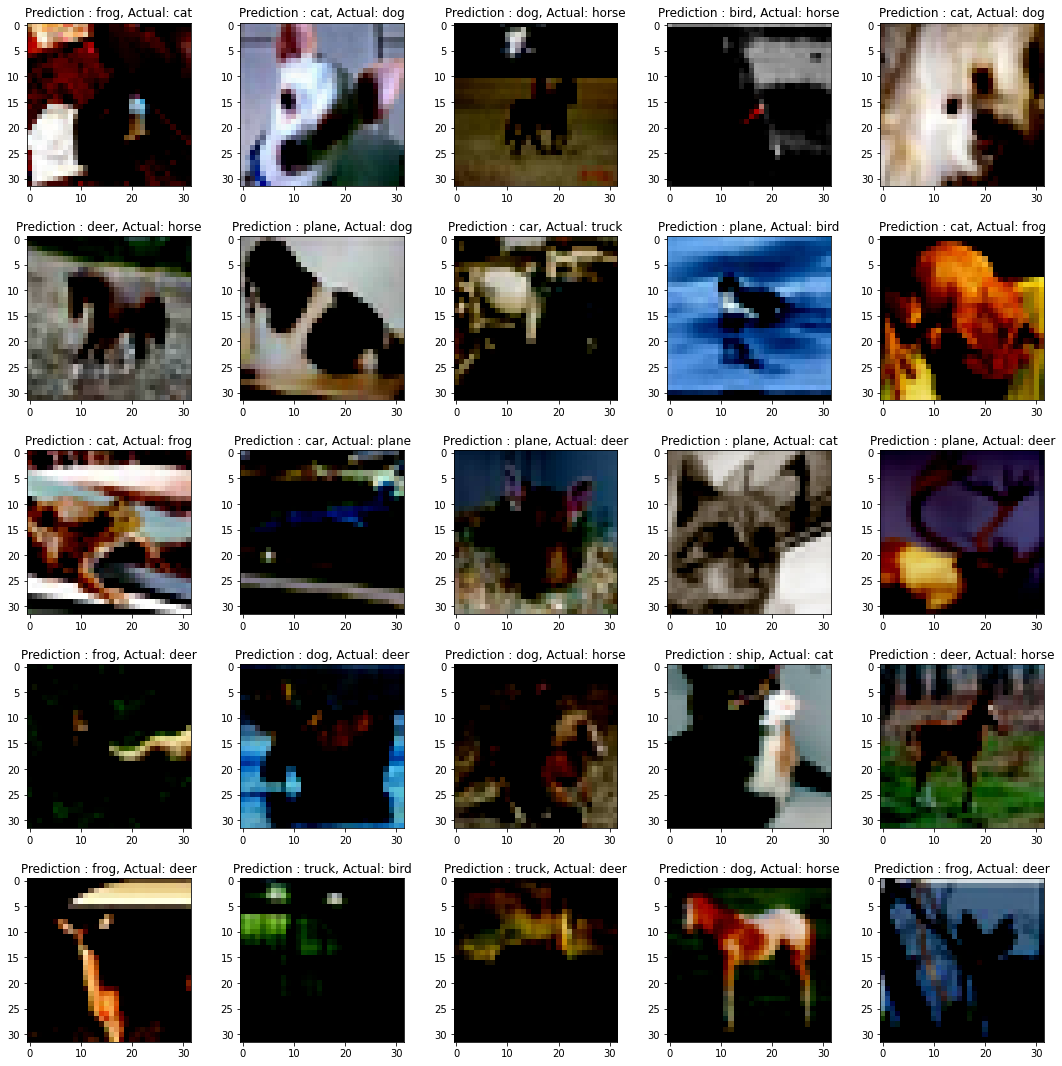

In [9]:
missClassImgs = getMisclassifiedImages(ResNet18(), testloader, device, 'savedModels/'+modelName+'.pt')
plotMisclassifiedImages(missClassImgs, classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


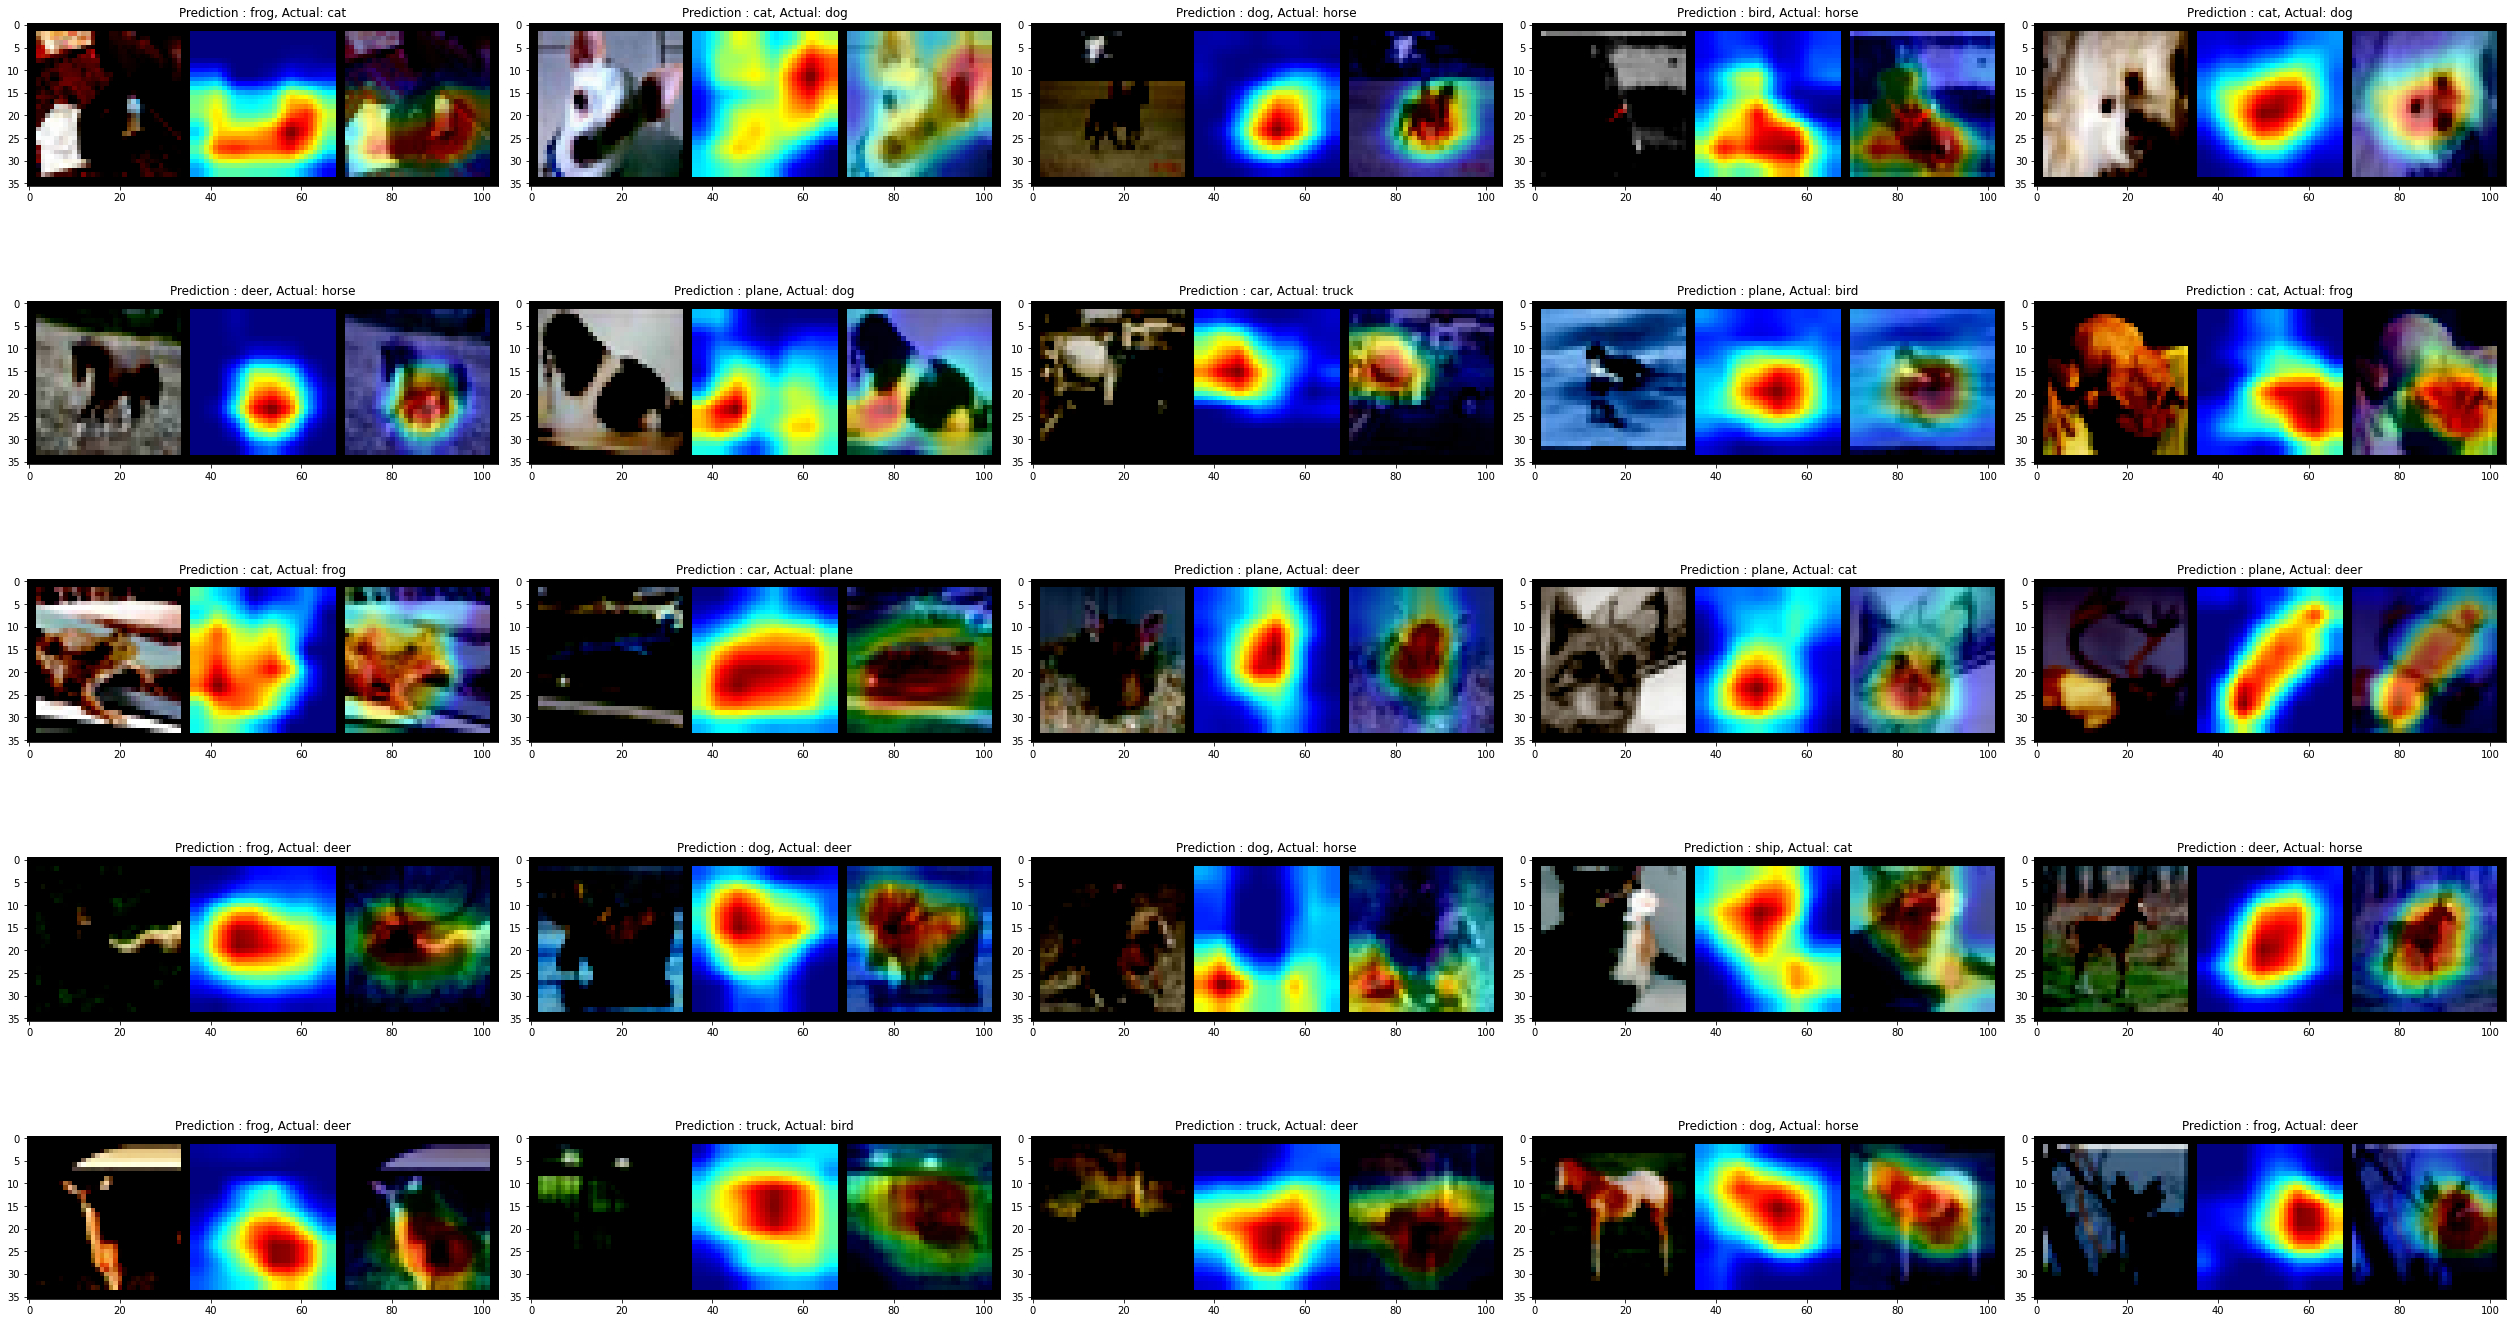

In [10]:
titles = getPredActualTitle(missClassImgs[:25], classes)
getGradCamOutput(MyResNet18(), 'resnet', 'savedModels/'+modelName+'.pt', 'layer4', missClassImgs[:25], titles)